In [1]:
import json
from anytree import Node, RenderTree
from anytree.search import find
import numpy as np
import random

class TaxonomyParser:

    """
    This class is a wrapper on a Tree class from the anytree library to hold
    different data hierarchies read from a JSON representation
    """

    def __init__(self, input_file=None):
        self.nodes = {"Root": Node("Root", parent=None, level=-1,
                                   training_count=0,
                                   avg_training_confidence=0)}
        self.taxo_mappings = {}
        self.root_key = None
        self.input_file = input_file
        # TODO check if file exists
        self.read_from_json()

    def read_from_json(self):
        """
        Read the taxonomy from a JSON file given as input
        """
        try:
            with open(self.input_file, "r") as f:
                data = json.load(f)
                n_levels = len(list(data.keys()))

                 # populate the tree
                for key, description in data.items():
                    description = description.replace(",", "-")
                    self.taxo_mappings[key] = description
                    
                    # description = arts, culture and entertainment
                    # dewcription = arts, culture and entertainment>animation
                    categories = description.split(">")
                    running_hierarchical_name = ""
                    for level, category_name in enumerate(categories):
                        running_hierarchical_name = running_hierarchical_name + ">" + category_name
                        
                        if level==0 and running_hierarchical_name not in self.nodes:
                            # if top-level category and doesn't exist yet, then create Node with Parent root
                            self.nodes[running_hierarchical_name] = Node(running_hierarchical_name,
                                                                         parent=self.nodes["Root"],
                                                                         simple_name=description,
                                                                         level=level,
                                                                         training_count=0, avg_training_confidence=np.nan)
                        elif running_hierarchical_name not in self.nodes:
                            # not a top-level category, create it with the proper Parent
                            self.nodes[running_hierarchical_name] = Node(running_hierarchical_name, parent=self.nodes[last_name],
                                                                         level=level,
                                                                         simple_name=description,
                                                                         training_count=0, avg_training_confidence=np.nan)
                        elif level != 0:
                            print(running_hierarchical_name)
                        # remember the current node
                        last_name = running_hierarchical_name
        except Exception as e:
            print(e)

# Read Trainings Data

In [293]:
from datetime import datetime
from bs4 import BeautifulSoup
import json

class Document():
    @staticmethod
    def get_datetime(date_str):
        date_str_cleaned = date_str.split('+')
        if len(date_str_cleaned) == 1:
            try:
                timestamp = datetime.strptime(date_str_cleaned[0], '%Y-%m-%dT%H:%M:%S.%fZ')
            except ValueError:
                timestamp = datetime.strptime(date_str_cleaned[0], '%Y-%m-%dT%H:%M:%S')
        elif len(date_str_cleaned) == 2:
            try:
                assert date_str_cleaned[1] == "00:00"
                timestamp = date_str_cleaned[0]
            except AssertionError:
                print(date_str)
            
        return timestamp
    
    def __init__(self, metadata, content, labels ):
        # metadata - {"publishedAt": "2019-12-02T23:18:45+00:00"}
        self.publishedAt = Document.get_datetime(metadata['publishedAt'])
        self.title = content['title'].replace("\n", "").replace("\t", "")
        self.content = ''.join(BeautifulSoup(content['fullTextHtml'], "html.parser").text.replace("\n", "").replace("\t", ""))
        self.sections = []
        for sec in content['sections']:
            self.sections.append(sec)
        self.labels = {}
        self.has_labels = False
        for label in labels:
            self.labels[label[0].replace(",", "-")] = label[1]  # taxonomy name -> confidence
            self.has_labels = True
        
            
    def get_text(self):
        return self.title + " " + self.content
    
    def get_training_sample(self):
        if self.has_labels:
            labels = ','.join(list(self.labels.keys()))
            yield self.get_text() + "\t" + labels

In [294]:
class TextCorpus():
    def __init__(self, fname=None, taxo_map=None):
        self.taxo = TaxonomyParser(input_file=taxo_map)
        self.input_file = fname
        self.documents = []
        # self.training_labels = {}
        # TODO: check if fname exists
        json_corpus = json.load(open(fname, 'r'))
        for doc in json_corpus:
            d = Document(doc['metadata'], doc['content'], doc['labels'])
            self.documents.append(d)
            for label, confidence in d.labels.items():
                label_split = label.split(">")
                running_name = ""
                if len(label_split) <= 2:
                    for cat in label_split:
                        running_name = running_name + ">" + cat
                        if running_name in self.taxo.nodes:
                            self.taxo.nodes[running_name].training_count += 1
                        else:
                            print(running_name + " not found")
                else:
                    print("hierarchy too long")
                    
                last_level = running_name
                last_level_avg_conf = self.taxo.nodes[last_level].avg_training_confidence
                    
                self.taxo.nodes[last_level].avg_training_confidence = \
                np.nansum([ (self.taxo.nodes[last_level].training_count-1)*last_level_avg_conf,
                           confidence]) / self.taxo.nodes[last_level].training_count
    
    def get_label_list(self):
        s = list(set(list(self.taxo.taxo_mappings.values())))
        return s
    
    def valid_docs(self):
        valid = 0
        for doc in self.documents:
            if doc.has_labels:
                valid += 1
        print(f"{str(valid)} documents out ouf {str(len(self.documents))} have labels")
    
    def get_taxo_names(self, level):
        for node_name, node_obj in self.taxo.nodes.items():
            if node_obj.level == level:
                yield node_obj.simple_name, node_obj.training_count
                
    def write_to_tsv(self, fname):
        with open(fname, mode="w") as f:
            f.write("text\tCategory\n")
            for doc in self.documents:
                for text in doc.get_training_sample():
                    f.write(text + "\n")
                    
                
    def gen_train_test(self, train_name, test_name, test_size=0.2, seed=42):
        random.seed(seed)
        with open(train_name, mode="w") as train_f:
            train_f.write("text\tCategory\n")
            with open(test_name, mode="w") as test_f:
                test_f.write("text\tCategory\n")
                for doc in self.documents:
                    r = random.random()
                    if r <= test_size:
                        # test
                        for text in doc.get_training_sample():
                            test_f.write(text + "\n")
                    else:
                        # train
                        for text in doc.get_training_sample():
                            train_f.write(text + "\n")

In [295]:
tp = TaxonomyParser(input_file='taxonomy_mappings.json')

In [296]:
tc = TextCorpus('train_data.json', 'taxonomy_mappings.json')

In [297]:
tc.valid_docs()

8481 documents out ouf 8537 have labels


In [298]:
tc.write_to_tsv("training_data_preprocessed.tsv")

In [299]:
tc.gen_train_test('train.tsv', 'test.tsv')

In [300]:
ll = tc.get_label_list()

In [301]:
len(ll)

433

In [148]:
s = 0
for name, nodes in tc.taxo.nodes.items():
    if nodes.level==1:
       # print(name + " " + str(nodes.training_count))
        s += nodes.training_count
print(s)
    

28537


In [ ]:
print(RenderTree(tc.taxo.nodes['Root'], maxlevel=2))

In [171]:
import seaborn as sns

In [174]:
name = [x for x,_ in tc.get_taxo_names(level=1)]
counts =  [y for _,y in tc.get_taxo_names(level=1)]

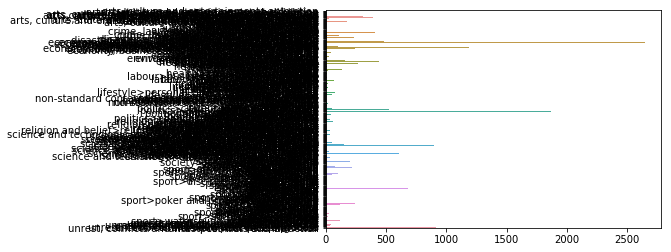

In [177]:
ax = sns.barplot(y=name, x=counts)

# Modelling

In [2]:
from farm.data_handler.data_silo import DataSilo
from farm.data_handler.processor import TextClassificationProcessor
from farm.modeling.optimization import initialize_optimizer
from farm.infer import Inferencer
from farm.modeling.adaptive_model import AdaptiveModel
from farm.modeling.language_model import LanguageModel
from farm.modeling.prediction_head import MultiLabelTextClassificationHead
from farm.modeling.tokenization import Tokenizer
from farm.train import Trainer
from farm.utils import set_all_seeds, MLFlowLogger, initialize_device_settings
import pandas as pd

I0720 22:40:34.791532 4541005248 file_utils.py:39] PyTorch version 1.5.1 available.


In [179]:
# ml_logger = MLFlowLogger(tracking_uri="https://public-mlflow.deepset.ai/")
# ml_logger.init_experiment(experiment_name="BBC_Articles", run_name="BBC News Articles")


In [303]:
set_all_seeds(seed=42)
device, n_gpu = initialize_device_settings(use_cuda=True)
n_epochs = 2
batch_size = 8 # larger batch sizes might use too much computing power in Colab
evaluate_every = 100

I0720 16:59:34.376077 4585033152 utils.py:84] device: cpu n_gpu: 0, distributed training: False, automatic mixed precision training: None


In [304]:
lang_model = "bert-base-cased"
do_lower_case = False

tokenizer = Tokenizer.load(
    pretrained_model_name_or_path=lang_model,
    do_lower_case=do_lower_case)

I0720 16:59:35.066936 4585033152 tokenization.py:92] Loading tokenizer of type 'BertTokenizer'
I0720 16:59:35.533119 4585033152 tokenization_utils_base.py:1254] loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-vocab.txt from cache at /Users/pmavrodiev/.cache/torch/transformers/5e8a2b4893d13790ed4150ca1906be5f7a03d6c4ddf62296c383f6db42814db2.e13dbb970cb325137104fb2e5f36fe865f27746c6b526f6352861b1980eb80b1


In [305]:
label_list = tc.get_label_list()
# ['entertainment', 'sport', 'politics', 'business', 'tech'] #labels in our data set
metric = "f1_macro" # desired metric for evaluation

processor = TextClassificationProcessor(tokenizer=tokenizer,
                                        max_seq_len=512, # BERT can only handle sequence lengths of up to 512
                                        data_dir='./', 
                                        label_list=label_list,
                                        label_column_name="Category", # our labels are located in the "genre" column
                                        metric=metric,
                                        quote_char='"',
                                        multilabel=True,
                                        train_filename="train.tsv",
                                        dev_filename=None,
                                        test_filename="test.tsv",
                                        dev_split=0.1 # this will extract 10% of the train set to create a dev set
                                        )

In [306]:
data_silo = DataSilo(
    processor=processor,
    batch_size=batch_size)

I0720 16:59:38.882901 4585033152 data_silo.py:197] 
Loading data into the data silo ... 
              ______
               |o  |   !
   __          |:`_|---'-.
  |__|______.-/ _ \-----.|       
 (o)(o)------'\ _ /     ( )      
 
I0720 16:59:38.884034 4585033152 data_silo.py:206] Loading train set from: train.tsv 
I0720 16:59:39.208085 4585033152 data_silo.py:152] Got ya 7 parallel workers to convert 6780 dictionaries to pytorch datasets (chunksize = 194)...
I0720 16:59:39.215245 4585033152 utils.py:298]  0    0    0    0    0    0    0 
I0720 16:59:39.216319 4585033152 utils.py:298] /w\  /w\  /w\  /w\  /w\  /w\  /w\
I0720 16:59:39.217137 4585033152 utils.py:298] /'\  / \  /'\  /'\  / \  / \  /'\
I0720 16:59:39.218055 4585033152 utils.py:298]             
Preprocessing Dataset train.tsv:   0%|          | 0/6780 [00:00<?, ? Dicts/s]I0720 16:59:52.835559 4585033152 processor.py:348] *** Show 2 random examples ***
I0720 16:59:52.842746 4585033152 processor.py:352] 

      .--.        __

In [307]:
# loading the pretrained BERT base cased model
language_model = LanguageModel.load(lang_model)
# prediction head for our model that is suited for classifying news article genres
prediction_head = MultiLabelTextClassificationHead(num_labels=len(label_list))

model = AdaptiveModel(
        language_model=language_model,
        prediction_heads=[prediction_head],
        embeds_dropout_prob=0.1,
        lm_output_types=["per_sequence"],
        device=device)

I0720 17:02:39.774240 4585033152 filelock.py:274] Lock 140404403397352 acquired on /Users/pmavrodiev/.cache/torch/transformers/b945b69218e98b3e2c95acf911789741307dec43c698d35fad11c1ae28bda352.9da767be51e1327499df13488672789394e2ca38b877837e52618a67d7002391.lock
I0720 17:02:39.776103 4585033152 file_utils.py:748] https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-config.json not found in cache or force_download set to True, downloading to /Users/pmavrodiev/.cache/torch/transformers/tmpoivdi4in


I0720 17:02:40.224061 4585033152 file_utils.py:752] storing https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-config.json in cache at /Users/pmavrodiev/.cache/torch/transformers/b945b69218e98b3e2c95acf911789741307dec43c698d35fad11c1ae28bda352.9da767be51e1327499df13488672789394e2ca38b877837e52618a67d7002391
I0720 17:02:40.225288 4585033152 file_utils.py:755] creating metadata file for /Users/pmavrodiev/.cache/torch/transformers/b945b69218e98b3e2c95acf911789741307dec43c698d35fad11c1ae28bda352.9da767be51e1327499df13488672789394e2ca38b877837e52618a67d7002391
I0720 17:02:40.227010 4585033152 filelock.py:318] Lock 140404403397352 released on /Users/pmavrodiev/.cache/torch/transformers/b945b69218e98b3e2c95acf911789741307dec43c698d35fad11c1ae28bda352.9da767be51e1327499df13488672789394e2ca38b877837e52618a67d7002391.lock
I0720 17:02:40.326050 4585033152 filelock.py:274] Lock 140404916882344 acquired on /Users/pmavrodiev/.cache/torch/transformers/d8f11f061e407be64c4d5d7867ee61d1

I0720 17:02:56.977555 4585033152 file_utils.py:752] storing https://cdn.huggingface.co/bert-base-cased-pytorch_model.bin in cache at /Users/pmavrodiev/.cache/torch/transformers/d8f11f061e407be64c4d5d7867ee61d1465263e24085cfa26abf183fdc830569.3fadbea36527ae472139fe84cddaa65454d7429f12d543d80bfc3ad70de55ac2
I0720 17:02:56.979058 4585033152 file_utils.py:755] creating metadata file for /Users/pmavrodiev/.cache/torch/transformers/d8f11f061e407be64c4d5d7867ee61d1465263e24085cfa26abf183fdc830569.3fadbea36527ae472139fe84cddaa65454d7429f12d543d80bfc3ad70de55ac2
I0720 17:02:56.980478 4585033152 filelock.py:318] Lock 140404916882344 released on /Users/pmavrodiev/.cache/torch/transformers/d8f11f061e407be64c4d5d7867ee61d1465263e24085cfa26abf183fdc830569.3fadbea36527ae472139fe84cddaa65454d7429f12d543d80bfc3ad70de55ac2.lock
I0720 17:02:56.981204 4585033152 modeling_utils.py:667] loading weights file https://cdn.huggingface.co/bert-base-cased-pytorch_model.bin from cache at /Users/pmavrodiev/.cache/t

I0720 17:02:59.162122 4585033152 modeling_utils.py:765] All model checkpoint weights were used when initializing BertModel.

I0720 17:02:59.163152 4585033152 modeling_utils.py:774] All the weights of BertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use BertModel for predictions without further training.
W0720 17:02:59.164580 4585033152 language_model.py:252] Could not automatically detect from language model name what language it is. 
	 We guess it's an *ENGLISH* model ... 
	 If not: Init the language model by supplying the 'language' param.
I0720 17:02:59.165455 4585033152 prediction_head.py:455] Prediction head initialized with size [768, 433]


In [308]:
model, optimizer, lr_schedule = initialize_optimizer(
        model=model,
        learning_rate=3e-5,
        device=device,
        n_batches=len(data_silo.loaders["train"]),
        n_epochs=n_epochs)

I0720 17:03:20.311180 4585033152 optimization.py:178] Loading optimizer `TransformersAdamW`: '{'correct_bias': False, 'weight_decay': 0.01, 'lr': 3e-05}'
I0720 17:03:20.406770 4585033152 optimization.py:249] Using scheduler 'get_linear_schedule_with_warmup'
I0720 17:03:20.407752 4585033152 optimization.py:263] Loading schedule `get_linear_schedule_with_warmup`: '{'num_warmup_steps': 150.4, 'num_training_steps': 1504}'


In [309]:
trainer = Trainer(
        model=model,
        optimizer=optimizer,
        data_silo=data_silo,
        epochs=n_epochs,
        n_gpu=n_gpu,
        lr_schedule=lr_schedule,
        evaluate_every=evaluate_every,
        device=device)

In [310]:
trainer.train()

I0720 17:03:42.266697 4585033152 train.py:254] 
 

          &&& &&  & &&             _____                   _             
      && &\/&\|& ()|/ @, &&       / ____|                 (_)            
      &\/(/&/&||/& /_/)_&/_&     | |  __ _ __ _____      ___ _ __   __ _ 
   &() &\/&|()|/&\/ '%" & ()     | | |_ | '__/ _ \ \ /\ / / | '_ \ / _` |
  &_\_&&_\ |& |&&/&__%_/_& &&    | |__| | | | (_) \ V  V /| | | | | (_| |
&&   && & &| &| /& & % ()& /&&    \_____|_|  \___/ \_/\_/ |_|_| |_|\__, |
 ()&_---()&\&\|&&-&&--%---()~                                       __/ |
     &&     \|||                                                   |___/
             |||
             |||
             |||
       , -=-~  .-^- _
              `

Train epoch 0/1 (Cur. train loss: 0.7018):   1%|          | 7/752 [03:03<5:10:23, 25.00s/it]

KeyboardInterrupt: 

In [ ]:
from google.colab import files


In [5]:
from pathlib import Path

In [7]:
model = Inferencer.load(Path('./content/bert-english-multi-cased'))

I0720 22:42:18.584059 4541005248 utils.py:84] device: cpu n_gpu: 0, distributed training: False, automatic mixed precision training: None
I0720 22:42:18.587824 4541005248 modeling_utils.py:667] loading weights file content/bert-english-multi-cased/language_model.bin from cache at content/bert-english-multi-cased/language_model.bin
I0720 22:42:20.755198 4541005248 modeling_utils.py:765] All model checkpoint weights were used when initializing BertModel.

I0720 22:42:20.756233 4541005248 modeling_utils.py:774] All the weights of BertModel were initialized from the model checkpoint at content/bert-english-multi-cased/language_model.bin.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use BertModel for predictions without further training.
I0720 22:42:20.757698 4541005248 adaptive_model.py:195] Found files for loading 1 prediction heads
W0720 22:42:20.759181 4541005248 prediction_head.py:449] `layer_dims` will be deprecated in future releases

In [8]:
from bs4 import BeautifulSoup


In [12]:
s="<p class=\"\">Suriname President Desi Bouterse said Monday he will seek re-election in the South American country despite being convicted of murder for the execution of political opponents.</p> <p class=\"\">\"Of course, with big bold letters. You will not be able to miss the name,\" Bouterse told a radio program when asked if he would appear on the list of candidates for the May 2020 elections.</p> <p class=\"\">Bouterse, 74, returned on Sunday from a state visit to China and will appeal Friday\'s judgement, according to his lawyer Irvin Kanhai.</p> <p class=\"\">A three-judge court convicted Bouterse over the executions of 15 regime opponents in December 1982 when he was the country\'s military ruler.</p> <p class=\"\">A two-time coup leader, two-term president and convicted drugs-trafficker, Bouterse has dominated Suriname\'s politics since taking power in a 1980 military coup.</p> <p class=\"\">The so-called \"December killings,\" in which the regime rounded up and executed 13 civilians and two military officers, have long clouded Bouterse\'s rule.</p> <p class=\"\">The president said he would address a meeting of his National Democratic Party (NDP) on Friday where a team of legal experts would explain the verdict to lawmakers.</p> <p class=\"\">On the radio program -- hosted by the government spokesman -- Bouterse thanked party supporters who turned out at the airport to greet him on his return from China on Sunday.</p> <p class=\"\">\"People are playing a political game with me and the supporters came to power me, to support me,\" he said.</p> <p class=\"\">He also snubbed calls from lawmakers for his resignation after being convicted Friday over the executions when he was the country\'s dictator in the 1980s.</p> <p class=\"\">Bouterse\'s five-year term ends August 12. There is no constitutional impediment to an incumbent running for another term.</p> <p class=\"\">At a press conference Sunday, Bouterse dismissed the conviction as a \"flip flop political game\".</p> <p class=\"\">\"It\'s a political process. They are trying to prove that I am guilty. When you have done it, I can imagine that it will affect you. I have other things on my mind.\"</p> <p class=\"\">Vice President Ashwin Adhin told a ruling party meeting on Friday that the president\'s murder conviction will never have legal force. \"We have enough resources to act within the rule of law\" to challenge it, he said.</p> <p class=\"\">He did not rule out seeking a pardon for the president once all legal appeals had been exhausted.</p> <p class=\"\">Bouterse has always denied involvement, saying the victims had been held for plotting a counter-coup with the help of the CIA, and had been shot while trying to escape.</p> <p class=\"\">ra/db/ec</p>"

In [14]:
s2 = ''.join(BeautifulSoup(s, "html.parser").text.replace("\n", "").replace("\t", ""))

In [16]:
basic_texts = [ {"text": s2} ]

In [17]:
result = model.inference_from_dicts(dicts=basic_texts)

Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.96 Batches/s]


In [31]:
max(result[0]['predictions'][0]['probability'])

0.46828175